In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 10

In [5]:
seed = 985
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 0 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  LHARVKFK_09_41_01
NN-MODEL FILENAME:  ./models/LHARVKFK_09_41_01_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 300000

In [11]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 15000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
print("HI_GRAIN = ", HI_GRAIN)

HI_GRAIN =  40


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################


    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s]
    ###############################################
    
    my_Q_TABLE = node_q_table

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((node_id%5 + 1)*0.1 + (iteration+1)*0.15) ,0.3,0.97)+ np.random.uniform(-0.01,0.01)
    print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            s = my_env.reset()
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = int(node_id%2)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN])



# GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 1233.56 MiB, increment: 1013.42 MiB
Quantization TIME:  0.01 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table

0 0.29553359246894945
1 0.3530529544455957
2 0.4481193825249832
3 0.5479524825598855
4 0.6540623490169967
5 0.30961217794296136
6 0.3418857856129376
7 0.44120857709777855
8 0.5449461004114811
9 0.6477829144338801
0 0.40305295444559575
1 0.4981193825249831
2 0.5979524825598855
3 0.7040623490169966
4 0.8096121779429615
5 0.39188578561293763
6 0.4912085770977785
7 0.5949461004114811
8 0.6977829144338801
9 0.7972460962746363
0 0.548119382524983
1 0.6479524825598854
2 0.7540623490169966
3 0.8596121779429614
4 0.9418857856129376
5 0.5412085770977785
6 0.6449461004114809
7 0.7477829144338801
8 0.8472460962746362
9 0.943955261482553
0 0.6979524825598854
1 0.8040623490169967
2 0.9096121779429615
3 0.9618857856129376
4 0.9612085770977785
5 0.694946100411481
6 0.7977829144338802
7 0.8972460962746363
8 0.9639552614825531
9 0.9689120846132796
0 0.8540623490169966
1 0.9596121779429614
2 0.9618857856129376
3 0.9612085770977785
4 0.964946100411481
5 0.8477829144338801
6 0.9472460962746362
7 0.96395526



ITERATION # 0
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 22778 EXPERIENCES:0:00:01.038226


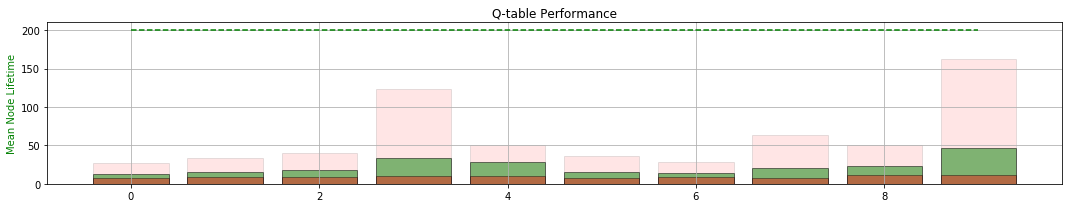

MEMORY COUNTER:  22778
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 4.732	LOSS : 4.668	LOSS : 4.471	LOSS : 4.301	LOSS : 4.233	LOSS : 4.034	
Validating... MEAN TIME:  184.655
LOSS : 4.194	LOSS : 4.008	LOSS : 3.999	LOSS : 3.996	LOSS : 3.904	LOSS : 3.880	
Validating... MEAN TIME:  200.0
LOSS : 3.823	LOSS : 3.832	LOSS : 3.910	LOSS : 3.857	LOSS : 3.754	LOSS : 3.898	
Validating... MEAN TIME:  200.0
LOSS : 3.734	LOSS : 3.702	LOSS : 3.853	LOSS : 3.869	LOSS : 3.833	LOSS : 3.711	
Validating... MEAN TIME:  199.985
LOSS : 3.712	LOSS : 3.818	LOSS : 3.996	LOSS : 4.058	LOSS : 3.878	LOSS : 4.077	
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:55.123074


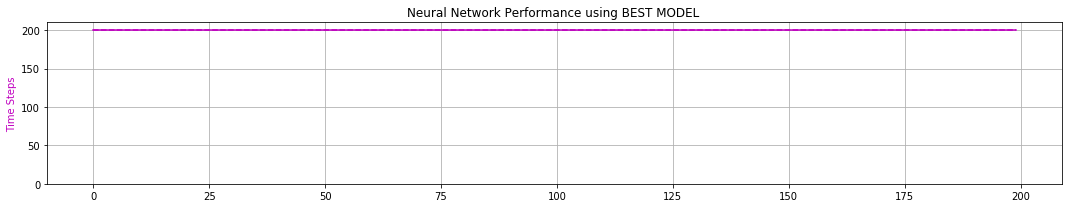

peak memory: 1348.21 MiB, increment: 1035.68 MiB
0 -max- [ 0.050  0.155  0.209  2.757]
0 -min- [-0.212 -1.804 -0.051 -0.079]

1 -max- [ 0.289  1.789  0.060  0.441]
1 -min- [-0.052 -0.245 -0.208 -2.738]

2 -max- [ 0.050  0.234  0.209  2.720]
2 -min- [-0.221 -1.785 -0.050 -0.178]

3 -max- [ 2.397  2.794  0.204  0.787]
3 -min- [-0.082 -0.560 -0.209 -2.505]

4 -max- [ 0.097  0.560  0.209  2.077]
4 -min- [-0.240 -1.219 -0.048 -0.228]

5 -max- [ 0.250  1.804  0.057  0.372]
5 -min- [-0.053 -0.242 -0.209 -2.766]

6 -max- [ 0.049  0.215  0.209  2.710]
6 -min- [-0.217 -1.784 -0.049 -0.213]

7 -max- [ 0.627  1.968  0.137  0.767]
7 -min- [-0.063 -0.402 -0.209 -2.654]

8 -max- [ 0.072  0.558  0.209  2.476]
8 -min- [-0.222 -1.605 -0.050 -0.207]

9 -max- [ 2.393  3.176  0.209  0.828]
9 -min- [-0.126 -0.575 -0.209 -2.237]

Quantization TIME:  0.01 minutes


ITERATION # 1
SMALLEST TIMESTEP in ITERATION 1: 8
REAL TIME TO GENERATE 66426 EXPERIENCES:0:00:04.251658


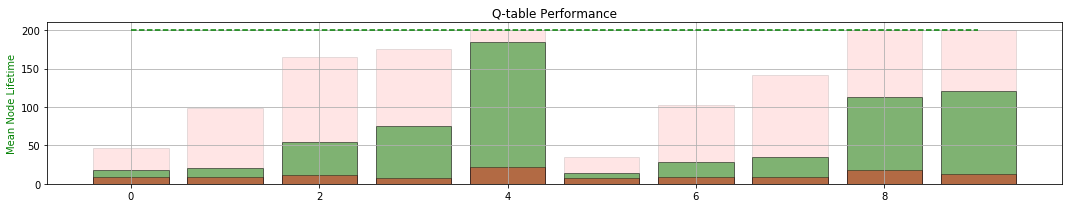

MEMORY COUNTER:  89204
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 2.922	LOSS : 2.620	LOSS : 2.630	LOSS : 2.679	LOSS : 2.781	LOSS : 2.748	
Validating... MEAN TIME:  196.89
LOSS : 2.593	LOSS : 2.609	LOSS : 2.741	LOSS : 2.610	LOSS : 2.644	LOSS : 2.704	
Validating... MEAN TIME:  200.0
LOSS : 2.628	LOSS : 2.592	LOSS : 2.475	LOSS : 2.522	LOSS : 2.546	LOSS : 2.606	
Validating... MEAN TIME:  198.975
LOSS : 2.469	LOSS : 2.376	LOSS : 2.378	LOSS : 2.402	LOSS : 2.262	LOSS : 2.531	
Validating... MEAN TIME:  200.0
LOSS : 2.475	LOSS : 2.415	LOSS : 2.456	LOSS : 2.491	LOSS : 2.426	LOSS : 2.467	
Validating... MEAN TIME:  199.91
TRAINING TIME:0:00:53.699911


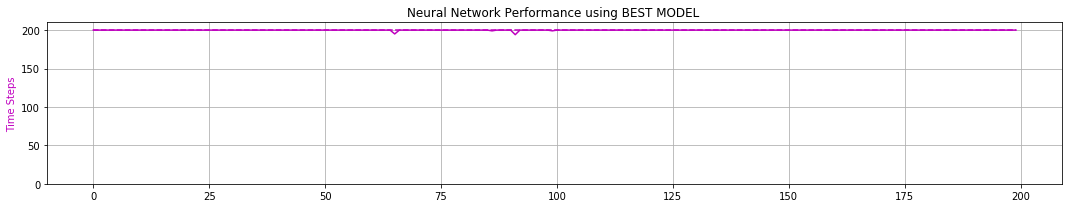

peak memory: 1398.75 MiB, increment: 1037.11 MiB
0 -max- [ 0.159  0.787  0.209  2.858]
0 -min- [-0.248 -1.924 -0.076 -0.959]

1 -max- [ 0.202  1.806  0.046  1.196]
1 -min- [-1.264 -1.872 -0.209 -2.643]

2 -max- [ 1.167  1.930  0.209  2.652]
2 -min- [-0.660 -1.794 -0.133 -1.797]

3 -max- [ 0.192  1.376  0.073  1.628]
3 -min- [-2.256 -2.404 -0.209 -2.235]

4 -max- [ 2.398  1.878  0.209  1.851]
4 -min- [-2.378 -2.637 -0.209 -1.578]

5 -max- [ 0.214  1.781  0.051  0.506]
5 -min- [-0.050 -0.584 -0.209 -2.759]

6 -max- [ 0.287  1.569  0.209  2.862]
6 -min- [-0.303 -1.918 -0.115 -1.553]

7 -max- [ 0.193  1.925  0.050  1.704]
7 -min- [-1.762 -2.007 -0.209 -2.915]

8 -max- [ 2.153  2.036  0.209  2.472]
8 -min- [-2.236 -2.230 -0.209 -1.868]

9 -max- [ 0.177  1.028  0.048  1.543]
9 -min- [-2.327 -2.391 -0.209 -1.913]

Quantization TIME:  0.01 minutes


ITERATION # 2
SMALLEST TIMESTEP in ITERATION 2: 9
REAL TIME TO GENERATE 113494 EXPERIENCES:0:00:04.420446


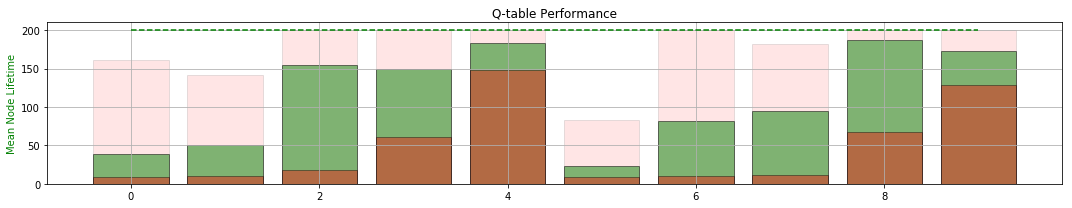

MEMORY COUNTER:  202698
Training Neural Network for 15000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.827	LOSS : 1.825	LOSS : 1.767	LOSS : 1.810	LOSS : 1.923	LOSS : 1.754	
Validating... MEAN TIME:  199.375
LOSS : 1.760	LOSS : 1.722	LOSS : 1.703	LOSS : 1.619	LOSS : 1.785	LOSS : 1.583	
Validating... MEAN TIME:  196.06
LOSS : 1.656	LOSS : 1.779	LOSS : 1.693	LOSS : 1.554	LOSS : 1.660	LOSS : 1.707	
Validating... MEAN TIME:  199.185
LOSS : 1.782	LOSS : 1.774	LOSS : 1.508	LOSS : 1.676	LOSS : 1.614	LOSS : 1.600	
Validating... MEAN TIME:  199.8
LOSS : 1.615	LOSS : 1.664	LOSS : 1.476	LOSS : 1.551	LOSS : 1.640	LOSS : 1.843	
Validating... MEAN TIME:  198.08
TRAINING TIME:0:00:57.071598


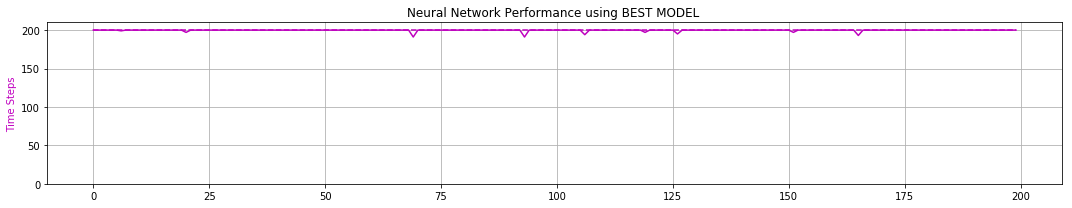

peak memory: 1409.05 MiB, increment: 1036.17 MiB
0 -max- [ 2.370  2.626  0.209  2.705]
0 -min- [-0.522 -1.792 -0.121 -1.519]

1 -max- [ 0.211  1.567  0.058  1.581]
1 -min- [-2.147 -2.224 -0.209 -2.333]

2 -max- [ 2.382  2.186  0.209  2.203]
2 -min- [-2.398 -2.814 -0.209 -1.702]

3 -max- [ 0.137  1.006  0.053  1.783]
3 -min- [-2.398 -2.708 -0.209 -1.576]

4 -max- [ 0.119  0.738  0.081  1.302]
4 -min- [-2.400 -2.932 -0.208 -1.347]

5 -max- [ 0.232  1.780  0.050  1.278]
5 -min- [-0.713 -1.892 -0.209 -2.718]

6 -max- [ 2.387  2.413  0.209  2.837]
6 -min- [-2.364 -2.602 -0.206 -1.559]

7 -max- [ 0.186  1.394  0.066  1.717]
7 -min- [-2.397 -2.741 -0.209 -2.176]

8 -max- [ 1.589  1.388  0.207  1.965]
8 -min- [-2.400 -2.614 -0.208 -1.952]

9 -max- [ 0.108  0.977  0.053  1.530]
9 -min- [-2.400 -2.608 -0.209 -1.582]

Quantization TIME:  0.01 minutes


ITERATION # 3
SMALLEST TIMESTEP in ITERATION 3: 9
REAL TIME TO GENERATE 151896 EXPERIENCES:0:00:04.725265


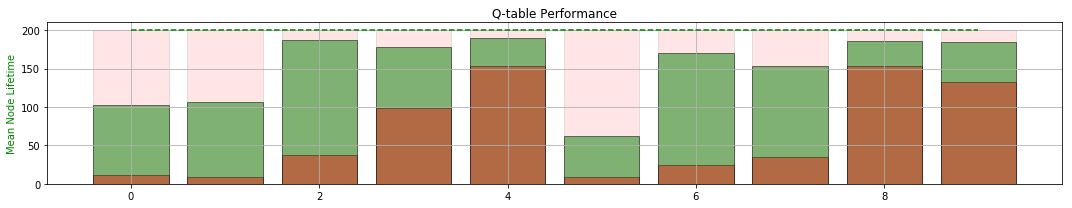

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 1.211	LOSS : 1.172	LOSS : 1.163	LOSS : 1.018	LOSS : 0.999	LOSS : 1.061	
Validating... MEAN TIME:  191.085
LOSS : 1.116	LOSS : 1.053	LOSS : 1.019	LOSS : 1.134	LOSS : 0.966	LOSS : 1.029	
Validating... MEAN TIME:  169.29
LOSS : 0.958	LOSS : 1.023	LOSS : 0.966	LOSS : 0.998	LOSS : 1.103	LOSS : 0.995	
Validating... MEAN TIME:  193.295
LOSS : 1.102	LOSS : 1.091	LOSS : 0.999	LOSS : 0.985	LOSS : 0.983	LOSS : 1.064	
Validating... MEAN TIME:  139.975
LOSS : 1.028	LOSS : 1.066	LOSS : 0.955	LOSS : 1.230	LOSS : 0.986	LOSS : 1.074	
Validating... MEAN TIME:  149.885
TRAINING TIME:0:00:51.046885


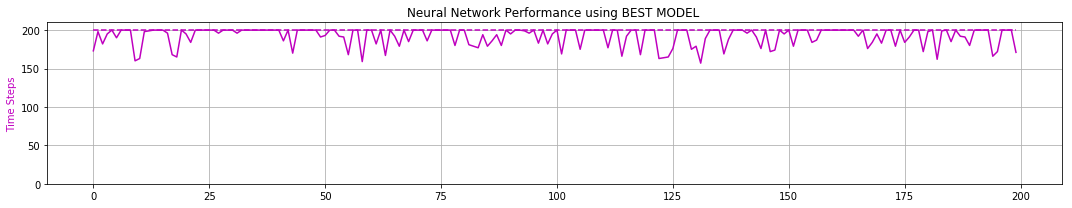

peak memory: 1461.71 MiB, increment: 978.80 MiB
0 -max- [ 2.393  2.408  0.209  2.630]
0 -min- [-2.385 -2.581 -0.186 -1.662]

1 -max- [ 0.294  1.398  0.102  1.892]
1 -min- [-2.398 -2.787 -0.209 -2.873]

2 -max- [ 1.238  1.561  0.205  2.026]
2 -min- [-2.396 -2.712 -0.204 -1.905]

3 -max- [ 0.758  0.939  0.078  1.646]
3 -min- [-2.398 -2.771 -0.209 -1.620]

4 -max- [ 0.856  0.993  0.119  1.584]
4 -min- [-2.399 -2.738 -0.204 -1.631]

5 -max- [ 0.189  1.781  0.112  1.951]
5 -min- [-2.363 -2.573 -0.209 -2.708]

6 -max- [ 2.371  2.210  0.209  1.965]
6 -min- [-2.400 -3.137 -0.209 -1.866]

7 -max- [ 0.214  1.012  0.078  1.908]
7 -min- [-2.399 -2.783 -0.209 -1.661]

8 -max- [ 0.725  0.990  0.128  1.733]
8 -min- [-2.400 -2.781 -0.200 -1.615]

9 -max- [ 0.663  0.978  0.088  1.630]
9 -min- [-2.400 -2.735 -0.208 -1.608]

Quantization TIME:  0.01 minutes


ITERATION # 4
SMALLEST TIMESTEP in ITERATION 4: 19
REAL TIME TO GENERATE 185190 EXPERIENCES:0:00:05.273071


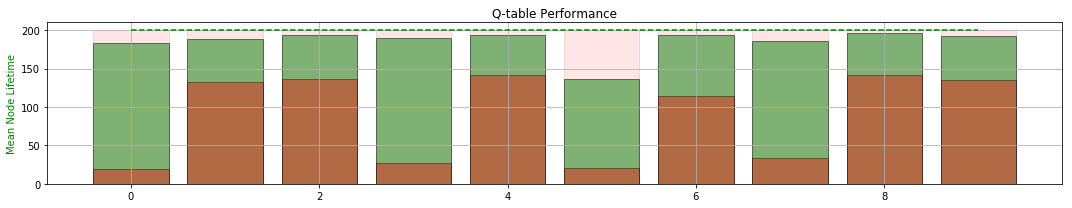

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.675	LOSS : 0.769	LOSS : 0.743	LOSS : 0.863	LOSS : 0.648	LOSS : 0.788	
Validating... MEAN TIME:  133.585
LOSS : 0.734	LOSS : 0.590	LOSS : 0.675	LOSS : 0.750	LOSS : 0.743	LOSS : 0.699	
Validating... MEAN TIME:  136.905
LOSS : 0.630	LOSS : 0.678	LOSS : 0.676	LOSS : 0.693	LOSS : 0.591	LOSS : 0.650	
Validating... MEAN TIME:  165.995
LOSS : 0.732	LOSS : 0.750	LOSS : 0.749	LOSS : 0.696	LOSS : 0.745	LOSS : 0.761	
Validating... MEAN TIME:  173.875
LOSS : 0.735	LOSS : 0.672	LOSS : 0.562	LOSS : 0.680	LOSS : 0.806	LOSS : 0.698	
Validating... MEAN TIME:  139.025
TRAINING TIME:0:00:46.691968


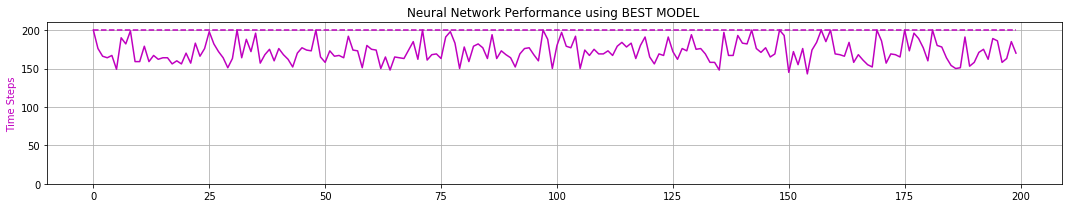

peak memory: 1444.96 MiB, increment: 1017.73 MiB
0 -max- [ 2.397  2.421  0.209  1.957]
0 -min- [-2.394 -2.768 -0.209 -1.359]

1 -max- [ 2.388  2.054  0.153  1.375]
1 -min- [-2.399 -2.949 -0.209 -1.607]

2 -max- [ 2.398  2.221  0.189  1.504]
2 -min- [-2.394 -2.975 -0.209 -1.367]

3 -max- [ 2.395  2.258  0.162  1.587]
3 -min- [-2.384 -2.922 -0.209 -1.668]

4 -max- [ 2.394  2.232  0.180  1.598]
4 -min- [-2.399 -2.960 -0.209 -1.378]

5 -max- [ 2.204  1.865  0.154  1.692]
5 -min- [-2.391 -2.958 -0.209 -1.771]

6 -max- [ 2.400  2.405  0.209  1.325]
6 -min- [-2.396 -2.922 -0.208 -1.368]

7 -max- [ 2.399  2.211  0.153  1.611]
7 -min- [-2.395 -2.941 -0.209 -1.675]

8 -max- [ 2.398  2.190  0.175  1.279]
8 -min- [-2.386 -2.927 -0.209 -1.359]

9 -max- [ 2.397  2.205  0.151  1.615]
9 -min- [-2.383 -2.960 -0.209 -1.454]

Quantization TIME:  0.01 minutes


ITERATION # 5
SMALLEST TIMESTEP in ITERATION 5: 156
REAL TIME TO GENERATE 183738 EXPERIENCES:0:00:05.501335


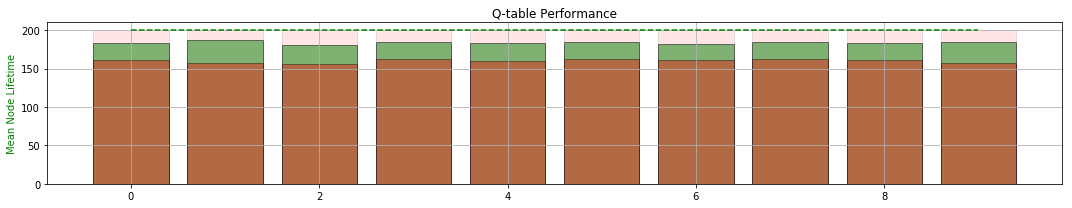

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.622	LOSS : 0.607	LOSS : 0.624	LOSS : 0.644	LOSS : 0.624	LOSS : 0.646	
Validating... MEAN TIME:  101.46
LOSS : 0.579	LOSS : 0.595	LOSS : 0.592	LOSS : 0.639	LOSS : 0.579	LOSS : 0.657	
Validating... MEAN TIME:  183.515
LOSS : 0.586	LOSS : 0.604	LOSS : 0.765	LOSS : 0.618	LOSS : 0.493	LOSS : 0.571	
Validating... MEAN TIME:  132.92
LOSS : 0.554	LOSS : 0.617	LOSS : 0.603	LOSS : 0.688	LOSS : 0.675	LOSS : 0.588	
Validating... MEAN TIME:  152.76
LOSS : 0.600	LOSS : 0.586	LOSS : 0.587	LOSS : 0.555	LOSS : 0.650	LOSS : 0.576	
Validating... MEAN TIME:  126.43
TRAINING TIME:0:00:46.096736


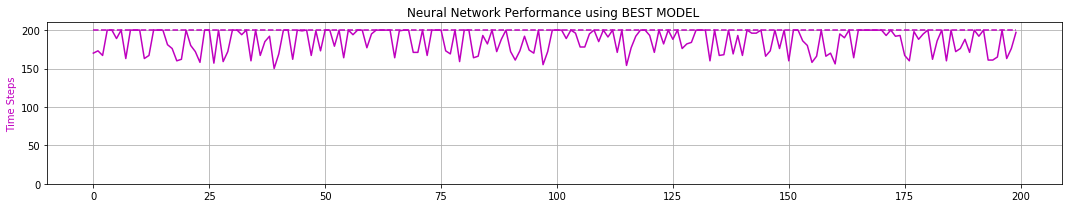

peak memory: 1492.19 MiB, increment: 986.22 MiB
0 -max- [ 2.400  2.166  0.189  1.318]
0 -min- [-0.131 -0.795 -0.052 -1.796]

1 -max- [ 2.400  2.165  0.137  1.041]
1 -min- [-0.126 -0.633 -0.056 -1.385]

2 -max- [ 2.400  2.237  0.165  1.085]
2 -min- [-0.127 -0.634 -0.050 -1.337]

3 -max- [ 2.400  2.079  0.140  1.044]
3 -min- [-0.123 -0.758 -0.050 -1.405]

4 -max- [ 2.399  2.232  0.200  1.178]
4 -min- [-0.139 -0.780 -0.068 -1.561]

5 -max- [ 2.400  2.246  0.139  1.058]
5 -min- [-0.121 -0.801 -0.051 -1.418]

6 -max- [ 2.400  2.260  0.194  1.389]
6 -min- [-0.148 -0.998 -0.068 -1.574]

7 -max- [ 2.399  2.160  0.137  1.026]
7 -min- [-0.125 -0.633 -0.048 -1.165]

8 -max- [ 2.399  2.162  0.155  1.219]
8 -min- [-0.127 -0.633 -0.055 -1.564]

9 -max- [ 2.400  2.159  0.138  1.041]
9 -min- [-0.116 -0.633 -0.060 -1.167]

Quantization TIME:  0.01 minutes


ITERATION # 6
SMALLEST TIMESTEP in ITERATION 6: 175
REAL TIME TO GENERATE 197111 EXPERIENCES:0:00:06.623946


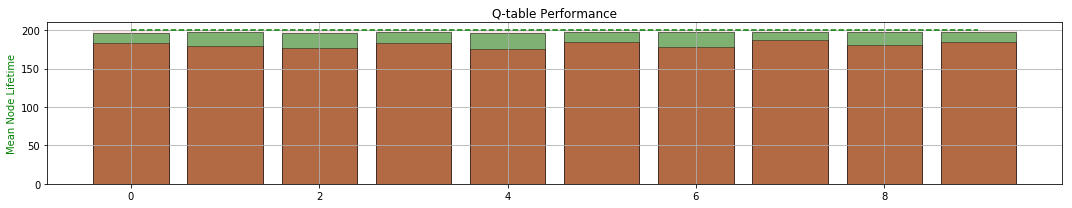

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.576	LOSS : 0.549	LOSS : 0.627	LOSS : 0.544	LOSS : 0.566	LOSS : 0.544	
Validating... MEAN TIME:  112.39
LOSS : 0.524	LOSS : 0.498	LOSS : 0.642	LOSS : 0.568	LOSS : 0.585	LOSS : 0.564	
Validating... MEAN TIME:  141.01
LOSS : 0.554	LOSS : 0.504	LOSS : 0.563	LOSS : 0.553	LOSS : 0.519	LOSS : 0.494	
Validating... MEAN TIME:  99.005
LOSS : 0.549	LOSS : 0.586	LOSS : 0.483	LOSS : 0.541	LOSS : 0.520	LOSS : 0.478	
Validating... MEAN TIME:  98.625
LOSS : 0.527	LOSS : 0.562	LOSS : 0.551	LOSS : 0.575	LOSS : 0.425	LOSS : 0.428	
Validating... MEAN TIME:  149.555
TRAINING TIME:0:00:41.848071


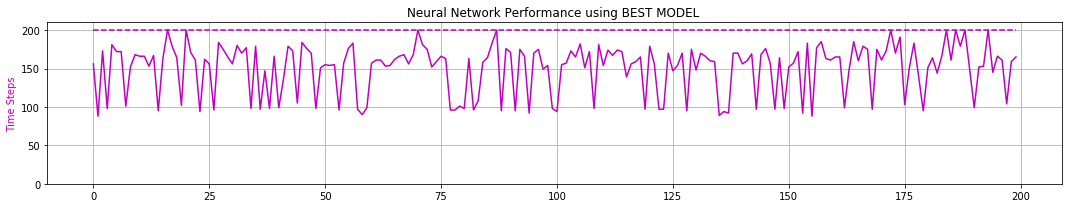

peak memory: 1451.22 MiB, increment: 1017.30 MiB
0 -max- [ 2.399  1.891  0.184  1.322]
0 -min- [-0.145 -0.785 -0.133 -1.840]

1 -max- [ 2.400  2.027  0.137  1.523]
1 -min- [-0.135 -0.781 -0.141 -1.559]

2 -max- [ 2.399  2.210  0.185  1.315]
2 -min- [-0.140 -0.798 -0.063 -1.235]

3 -max- [ 2.399  2.047  0.147  1.269]
3 -min- [-0.152 -0.635 -0.070 -1.248]

4 -max- [ 2.399  2.222  0.206  1.411]
4 -min- [-0.142 -0.801 -0.160 -1.875]

5 -max- [ 2.399  1.888  0.136  1.279]
5 -min- [-0.140 -0.631 -0.092 -1.238]

6 -max- [ 2.400  2.081  0.194  1.278]
6 -min- [-0.141 -0.756 -0.140 -1.869]

7 -max- [ 2.400  1.887  0.135  1.289]
7 -min- [-0.132 -0.633 -0.071 -0.993]

8 -max- [ 2.399  2.069  0.180  1.260]
8 -min- [-0.136 -0.814 -0.059 -1.474]

9 -max- [ 2.400  1.892  0.137  1.062]
9 -min- [-0.134 -0.630 -0.075 -1.244]

Quantization TIME:  0.01 minutes


ITERATION # 7
SMALLEST TIMESTEP in ITERATION 7: 17
REAL TIME TO GENERATE 105490 EXPERIENCES:0:00:02.592862


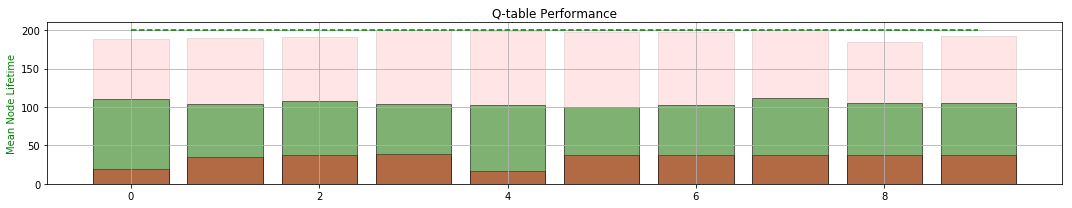

MEMORY COUNTER:  300000
Training Neural Network for 15000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
LOSS : 0.890	LOSS : 0.800	

In [ ]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        time_step = 0
        s = env.reset()

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, -1).astype(np.float16)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [ ]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

In [ ]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [ ]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))